In [1]:
DIR = 'F:/'
TRAIN_DF_PATH = DIR + "train.csv"
TEST_DF_PATH = DIR + 'test.csv'
TRAIN_IMG_PATH = DIR + "train_images/"
TEST_IMG_PATH = DIR + 'test_images/'

In [2]:
BASE_DIR = 'F:/'
TRAIN_IMAGE_DIR = 'F:/train_images'
TEST_IMAGE_DIR = 'F:/test_images'
train_csv = 'F:/train.csv'
test_csv = 'F:/test.csv'
IMAGE_SIZE = 224
BATCH_SIZE = 10

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
train_df = pd.read_csv(train_csv)
train_df.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
test_df = pd.read_csv(test_csv)
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [6]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'
test_df['id_code'] = test_df['id_code'].astype(str)+'.png'

In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [8]:
train_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'training',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)


Found 2930 validated image filenames belonging to 5 classes.


In [9]:
val_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'validation',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 732 validated image filenames belonging to 5 classes.


In [10]:
test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = None,
    x_col = 'id_code',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    directory = TEST_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)


Found 1928 validated image filenames.


In [11]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
encoded_diagnosis = onehot_encoder.fit_transform(train_df[['diagnosis']])
print(encoded_diagnosis)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [12]:

from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers import Dropout, GaussianNoise, GaussianDropout,GlobalAveragePooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
from keras.models import load_model

In [13]:
from keras.applications.inception_v3 import InceptionV3
inet = InceptionV3(include_top = False, weights='imagenet', input_shape=(224,224,3))
model = Sequential()
model.add(inet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [17]:
model.fit_generator(generator=train_gen,              
                                    steps_per_epoch=len(train_gen)//BATCH_SIZE,
                                    validation_data=val_gen,                    
                                    validation_steps=len(val_gen)//BATCH_SIZE,
                                    epochs=50,
                                    verbose=1)

model.save('Inception.h5')

Epoch 1/50
29/29 [==============================] - 246s 8s/step - loss: 0.5299 - accuracy: 0.7269 - val_loss: 0.3002 - val_accuracy: 0.8171
Epoch 2/50
29/29 [==============================] - 235s 8s/step - loss: 0.3066 - accuracy: 0.8772 - val_loss: 0.5935 - val_accuracy: 0.8714
Epoch 3/50
29/29 [==============================] - 232s 8s/step - loss: 0.2714 - accuracy: 0.8903 - val_loss: 0.5531 - val_accuracy: 0.8943
Epoch 4/50
29/29 [==============================] - 236s 8s/step - loss: 0.2764 - accuracy: 0.8883 - val_loss: 0.3691 - val_accuracy: 0.9029
Epoch 5/50
29/29 [==============================] - 234s 8s/step - loss: 0.2514 - accuracy: 0.9007 - val_loss: 0.4929 - val_accuracy: 0.8886
Epoch 6/50
29/29 [==============================] - 247s 9s/step - loss: 0.2673 - accuracy: 0.8903 - val_loss: 0.1158 - val_accuracy: 0.8800
Epoch 7/50
29/29 [==============================] - 236s 8s/step - loss: 0.2517 - accuracy: 0.8952 - val_loss: 0.2663 - val_accuracy: 0.9029
Epoch 8/50
29

In [18]:
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

193/193 [==============================] - 502s 3s/step


In [28]:
accuracy, val_accuracy =model.history.history['accuracy'], model.history.history['val_accuracy']
loss, val_loss = model.history.history['loss'], model.history.history['val_loss']
epochs = range(len(accuracy))
import matplotlib.pyplot as plt

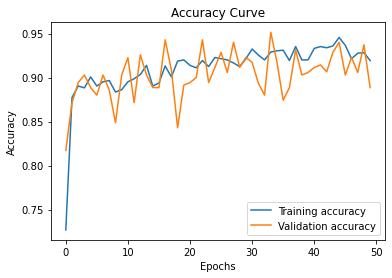

In [30]:
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

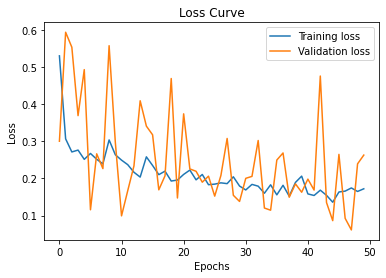

In [31]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()